# B881 推文代码

- title: 交互项要不要加？理论解释与实操建议

>**Source:** Rimpler, A., Kiers, H. A. L., & Van Ravenzwaaij, D. (2025). To interact or not to interact: The pros and cons of including interactions in linear regression models. Behavior Research Methods, 57(3). [Link](https://doi.org/10.3758/s13428-025-02613-6), [PDF](https://link.springer.com/content/pdf/10.3758/s13428-025-02613-6.pdf), [-PDF2-](https://files.osf.io/v1/resources/6utws_v1/providers/osfstorage/66a387ee9007a349452402b9?action=download&direct&version=2), [Google](<https://scholar.google.com/scholar?q=To interact or not to interact: The pros and cons of including interactions in linear regression models>).

### 2.2 交互效应的“形状”：协同、缓冲与对抗

Rimpler 等（2025）强调，交互效应不只是“有或没有”的问题，还涉及其具体“形状（shape）”。论文采用 McCabe 和 King 的框架，将 $x$、$z$、$xz$ 的效应组合划分为三类：

- **协同型**（synergistic）：$\beta_1,\beta_2,\beta_3$ 同号。两个自变量分别对因变量有同方向影响，并且交互项进一步放大这一影响。
  
- **缓冲型**（buffering）：$\beta_1$ 与 $\beta_2$ 异号，$\beta_3$ 与其中一个主效应同号。交互项在某种意义上“缓冲”了其中一个主效应的影响。
- **对抗型**（antagonistic）：$\beta_1,\beta_2$ 同号，而 $\beta_3$ 异号。交互项会在某些区域抵消甚至反向改变主效应的作用。

在三维空间中，含交互项时 $x$–$z$–$y$ 的关系不再是一个平面，而是一个弯曲的曲面。常见的“简单斜率图”只是这个曲面在几个水平上的切片，因此很难完整反映交互效应的整体形态。


下面的模型都基于如下模型设定：

$$y = \beta_0 + \beta_X x + \beta_Z z + \beta_{XZ} x z$$

* 无交互：$\beta_X = 1,\ \beta_Z = 1,\ \beta_{XZ} = 0$
* 协同交互 (synergistic)：$\beta_X = 1,\ \beta_Z = 1,\ \beta_{XZ} = 1$
* 缓冲交互 (buffering)：$\beta_X = 1,\ \beta_Z = -1,\ \beta_{XZ} = 1$
* 对抗交互 (antagonistic)：$\beta_X = 1,\ \beta_Z = 1,\ \beta_{XZ} = -1$

下面这段代码会：

1. 在当前工作路径下创建 `Figs` 子文件夹；
2. 对每一种参数组合绘制一幅 3D 曲面图；
3. 每一幅图单独保存为 `Figs` 下的 PNG 文件，尺寸为 `(8, 6)`。


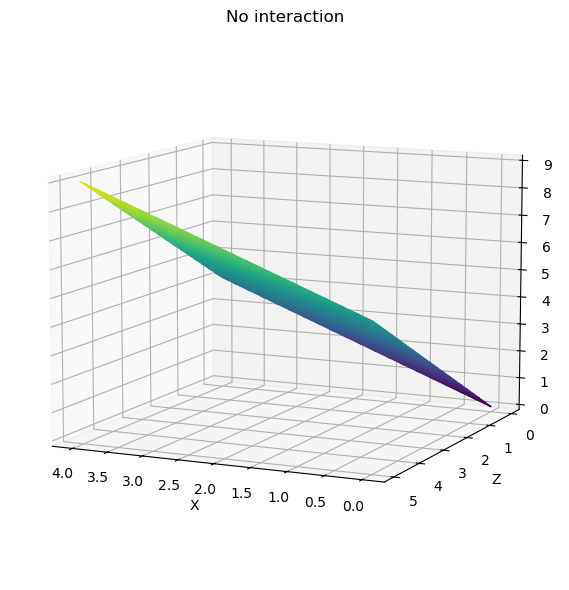

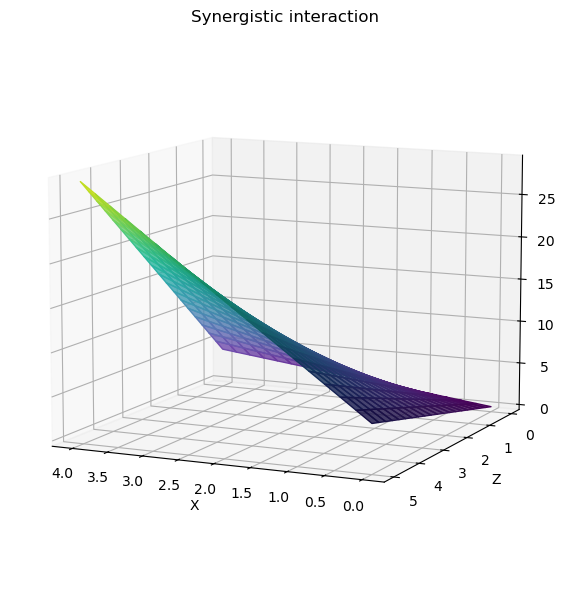

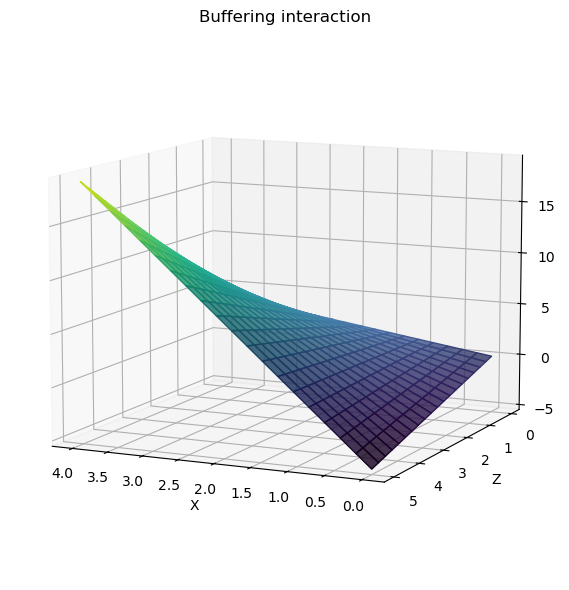

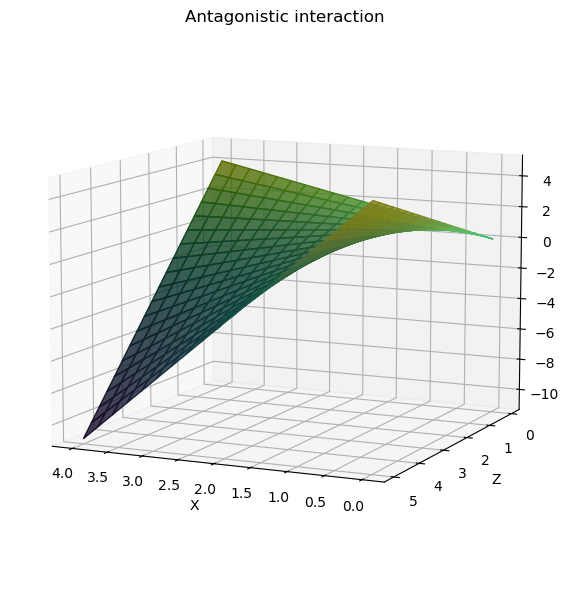

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# 创建存储图片的文件夹
os.makedirs("Figs", exist_ok=True)

# 生成网格数据
x = np.linspace(0, 4, 20)
z = np.linspace(0, 5, 20)
X, Z = np.meshgrid(x, z)

# （a）无交互：Y = X + Z
Y_no_interaction = X + Z

# （b）协同交互：Y = X + Z + X*Z
Y_synergistic = X + Z + X * Z

# （c）缓冲交互：Y = X - Z + X*Z
Y_buffering = X - 1*Z + X * Z

# （d）拮抗交互：Y = X + Z - X*Z
Y_antagonistic = X + Z - X * Z

# 绘图函数
def plot_3d(X, Z, Y, title, filename):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # ---------- 调整视角 ----------
    # elev=10：仰角 10度；azim=115：方位角115度（可根据需求修改）
    ax.view_init(elev=10, azim=115)  
    
    # ---------- 调整光照与表面效果 ----------
    # 方式1：通过lightsource增强光照质感
    from matplotlib.colors import LightSource
    ls = LightSource(azdeg=45, altdeg=30)  # 光源的方位角和仰角
    rgb = ls.shade(Y, cmap=plt.cm.viridis, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(X, Z, Y, rstride=1, cstride=1, facecolors=rgb, alpha=0.8)
    
    # 方式2：直接用cmap（若不需要复杂光照，可替换上面的lightsource代码）
    # surf = ax.plot_surface(X, Z, Y, cmap='viridis', alpha=0.8, rstride=1, cstride=1)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')
    ax.set_title(title)
    plt.tight_layout()
    # 先保存图片到本地
    plt.savefig(f"Figs/{filename}")
    # 再显示图片（会阻塞程序，关闭窗口后继续运行）
    plt.show()
    
# 绘制并保存四幅图
plot_3d(X, Z, Y_no_interaction, "No interaction", "B881-01-no_interaction.png")
plot_3d(X, Z, Y_synergistic, "Synergistic interaction", "B881-02-synergistic.png")
plot_3d(X, Z, Y_buffering, "Buffering interaction", "B881-03-buffering.png")
plot_3d(X, Z, Y_antagonistic, "Antagonistic interaction", "B881-04-antagonistic.png")




## 6. Stata 实操

### 6.1 模拟“忽略交互导致主效应反号”

下面这个练习用于展示：当真实模型为对抗型交互时，如果在估计时不加入交互项，主效应估计可能出现“方向相反”甚至“接近零”的现象。


In [1]:
clear all
set seed 123456

* 1. 构造总体数据
set obs 200000

gen x = rnormal(1,1)
gen z = rnormal(2,1)

scalar b0 = 0
scalar b1 = 1
scalar b2 = 1
scalar b3 = -1      // 对抗型交互

gen e = rnormal(0,1)
gen y = b0 + b1*x + b2*z + b3*x*z + e

* 2. 在总体数据上估计两种模型

* (1) 不含交互项的简单模型
qui eststo m1: reg y x z

* (2) 含交互项的完整模型
qui eststo m2: reg y c.x##c.z

* 结果对比
esttab m1 m2, nogap se scalar(N rss r2) ///
    label b(3) se(3) compress ///
    star(* 0.10 ** 0.05 *** 0.01)


Running D:\stata19/profile.do ...


Number of observations (_N) was 0, now 200,000.

------------------------------------------
                       (1)          (2)   
                         y            y   
------------------------------------------
x                   -1.003***     0.991***
                   (0.003)      (0.005)   
z                   -0.003        0.998***
                   (0.003)      (0.003)   
x # z                            -0.996***
                                (0.002)   
Constant             2.009***     0.006   
                   (0.008)      (0.007)   
------------------------------------------
Observations        200000       200000   
rss              399063.909    200126.951   
r2                   0.336        0.667   
------------------------------------------
Standard errors in parentheses
* p<0.10, ** p<0.05, *** p<0.01


##提示词
帮我编写讲义风格的 Markdown 文本：
1. 使用 Latex 数学公式说明上述两列的 DGP，并解释遗漏交乘项可能导致的后果
2. 解释上述两列结果，并于理论预期进行对比

在这段代码中，我们按前文设定了一个对抗型交互的 DGP：$y_i=\beta_0+\beta_1x_i+\beta_2z_i+\beta_3x_iz_i+\varepsilon_i$，其中 $\beta_0=0,\beta_1=1,\beta_2=1,\beta_3=-1$。列 (1) 实际估计的是遗漏交乘项的简化模型 $y_i=\alpha_0+\alpha_1x_i+\alpha_2z_i+u_i$，而 $u_i=\beta_3x_iz_i+\varepsilon_i=-x_iz_i+\varepsilon_i$ 同时与 $x_i,z_i$ 相关，所以简化模型中的主效应系数只是“用平面逼近弯曲交互曲面”的折中结果，正好对应前文所说那种“遗漏交互会让主效应反号或被抹平”的情形。

从估计结果看，含交乘项的列 (2) 基本恢复了 DGP：$\hat\beta_1\approx0.991,\hat\beta_2\approx0.998,\hat\beta_3\approx-0.996,\hat\beta_0\approx0$，且 $R^2\approx0.667$；而列 (1) 中却得到 $\hat\alpha_1\approx-1.003,\hat\alpha_2\approx-0.003,\hat\alpha_0\approx2.009$，$R^2\approx0.336$。如果读者只看到列 (1)，会自然得出“$x$ 对 $y$ 显著负向、$z$ 几乎没有作用”的结论，这与真实机制完全相反，也直观印证了前文的核心观点：在理论上存在重要交互时，简单删掉交乘项，比“多估计一个不显著的交互”危险得多。



### 6.2 变量中心化前后的比较

最后，可以通过一个小练习帮助读者理解：均值中心化并不改变交互项的估计和检验结果，而主要影响主效应的解释方式。


In [ ]:
clear all
set seed 2025
set obs 2000

gen x = rnormal(1,1)
gen z = rnormal(2,1)
gen e = rnormal(0,1)

scalar b0 = 0
scalar b1 = 1
scalar b2 = 1
scalar b3 = 0.5

gen y = b0 + b1*x + b2*z + b3*x*z + e

* (1) 未中心化的含交互模型
qui eststo m1: reg y c.x##c.z

* (2) 均值中心化后的含交互模型
qui summ x
gen x_c = x - r(mean)
qui summ z
gen z_c = z - r(mean)

qui eststo m2: reg y c.x_c##c.z_c

* 结果对比
esttab m1 m2, nogap se scalar(N rss r2) ///
    label b(3) se(3) compress ///
    star(* 0.10 ** 0.05 *** 0.01)   

Number of observations (_N) was 0, now 2,000.

------------------------------------------
                       (1)          (2)   
                         y            y   
------------------------------------------
x                    1.015***             
                   (0.048)                
z                    1.020***             
                   (0.030)                
x # z                0.495***             
                   (0.021)                
x_c                               2.014***
                                (0.022)   
z_c                               1.514***
                                (0.022)   
x_c # z_c                         0.495***
                                (0.021)   
Constant            -0.011        4.055***
                   (0.067)      (0.022)   
------------------------------------------
Observations          2000         2000   
rss               1907.243     1907.243   
r2                   0.874        0.874   
-------